In [48]:
import re

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
import gensim
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import ngrams
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

c:\users\jurus\desktop\machine learing lab auta\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [65]:
#DATA

df_fake = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/Fake.csv")
df_true = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/True.csv")

# Adding a column to indicate whether the news is true or fake
df_true['isfake'] = 0
df_fake['isfake'] = 1

df_1 = pd.concat([df_true, df_fake]).reset_index(drop=True)
df_1.drop(columns=['date'], inplace=True)

# Combining 'title' and 'text' colmuns together
#df['original'] = df['tweet']
df_1['original'] = df_1['title'] + ' ' + df_1['text']

In [66]:
df_train = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data/Constraint_Train.csv")
df_test = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data/english_test_with_labels.csv")

df_2 = pd.concat([df_train, df_test]).reset_index(drop=True)

#Changing labels: real to 1 and false to 0
df_2['label'] = df_2['label'].replace({'real': 1})
df_2['label'] = df_2['label'].replace({'fake': 0})
df_2['isfake'] = df_2['label']
counter_fake = 0
counter_true = 0
for ind in df_2.index:
    if df_2['label'][ind] == 0:
        counter_true+=1
    elif df_2['label'][ind] == 1:
        counter_fake+=1

# Combining 'title' and 'text' colmuns together
df_2.drop(columns=['label'], inplace=True)
df_2['original'] = df_2['tweet']
df_2.drop(columns=['tweet'], inplace=True)
df_2['clean'] = df_2['original'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)



In [68]:
df_2.drop(columns=['original'], inplace=True)
df_2['original'] = df_2['clean']
df_2.drop(columns=['clean'], inplace=True)
df_2.drop(columns=['id'], inplace=True)

In [67]:
df_1.drop(columns=['title'], inplace=True)
df_1.drop(columns=['text'], inplace=True)
df_1.drop(columns=['subject'], inplace=True)

In [69]:
df = pd.concat([df_1, df_2]).reset_index(drop=True)
df

isfake                                           original
0           0  As U.S. budget fight looms, Republicans flip t...
1           0  U.S. military to accept transgender recruits o...
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...
3           0  FBI Russia probe helped by Australian diplomat...
4           0  Trump wants Postal Service to charge 'much mor...
...       ...                                                ...
53453       1  #CoronaVirusUpdates: State-wise details of Tot...
53454       0  Tonight 12(midnight) onwards Disaster Manageme...
53455       1  296 new cases of #COVID19Nigeria; Plateau-85 E...
53456       1  RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...
53457       1  More than half of pregnant women recently admi...

[53458 rows x 2 columns]

In [70]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')
stop_words.extend(['washington', 'reuters', 'video', 'tweet', 'tweets'])

# Removing stopwords and words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result

df['clean'] = df['original'].apply(preprocess)

# All unique words present in dataset in one string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
print(df['clean_joined'])

0        budget fight looms republicans flip fiscal scr...
1        military accept transgender recruits monday pe...
2        senior republican senator mueller special coun...
3        russia probe helped australian diplomat trump ...
4        trump wants postal service charge amazon shipm...
                               ...                        
53453    state wise details total confirmed covid cases...
53454    tonight midnight onwards disaster management i...
53455    cases covid nigeria plateau enugu lagos rivers...
53456    cdcemergency cdcgov stop shop covid resources ...
53457    half pregnant women recently admitted hospital...
Name: clean_joined, Length: 53458, dtype: object


In [71]:
df['clean_joined'][53457]

'half pregnant women recently admitted hospital covid infection black ethnic minority groups study finds'

In [72]:
#COUNT VECTORIZER - counts  the occurrence of each word for every single text in order to create a vector

from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size=0.2)

vectorizer = CountVectorizer()
vectorizer.fit(df['clean_joined'])
# Transforming training and validation data using count vectorizer object
X_train_count = vectorizer.transform(X_train.values)
X_test_count = vectorizer.transform(X_test.values)


Model accuracy is :  0.8990834268612047
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      5051
           1       0.89      0.93      0.91      5641

    accuracy                           0.90     10692
   macro avg       0.90      0.90      0.90     10692
weighted avg       0.90      0.90      0.90     10692



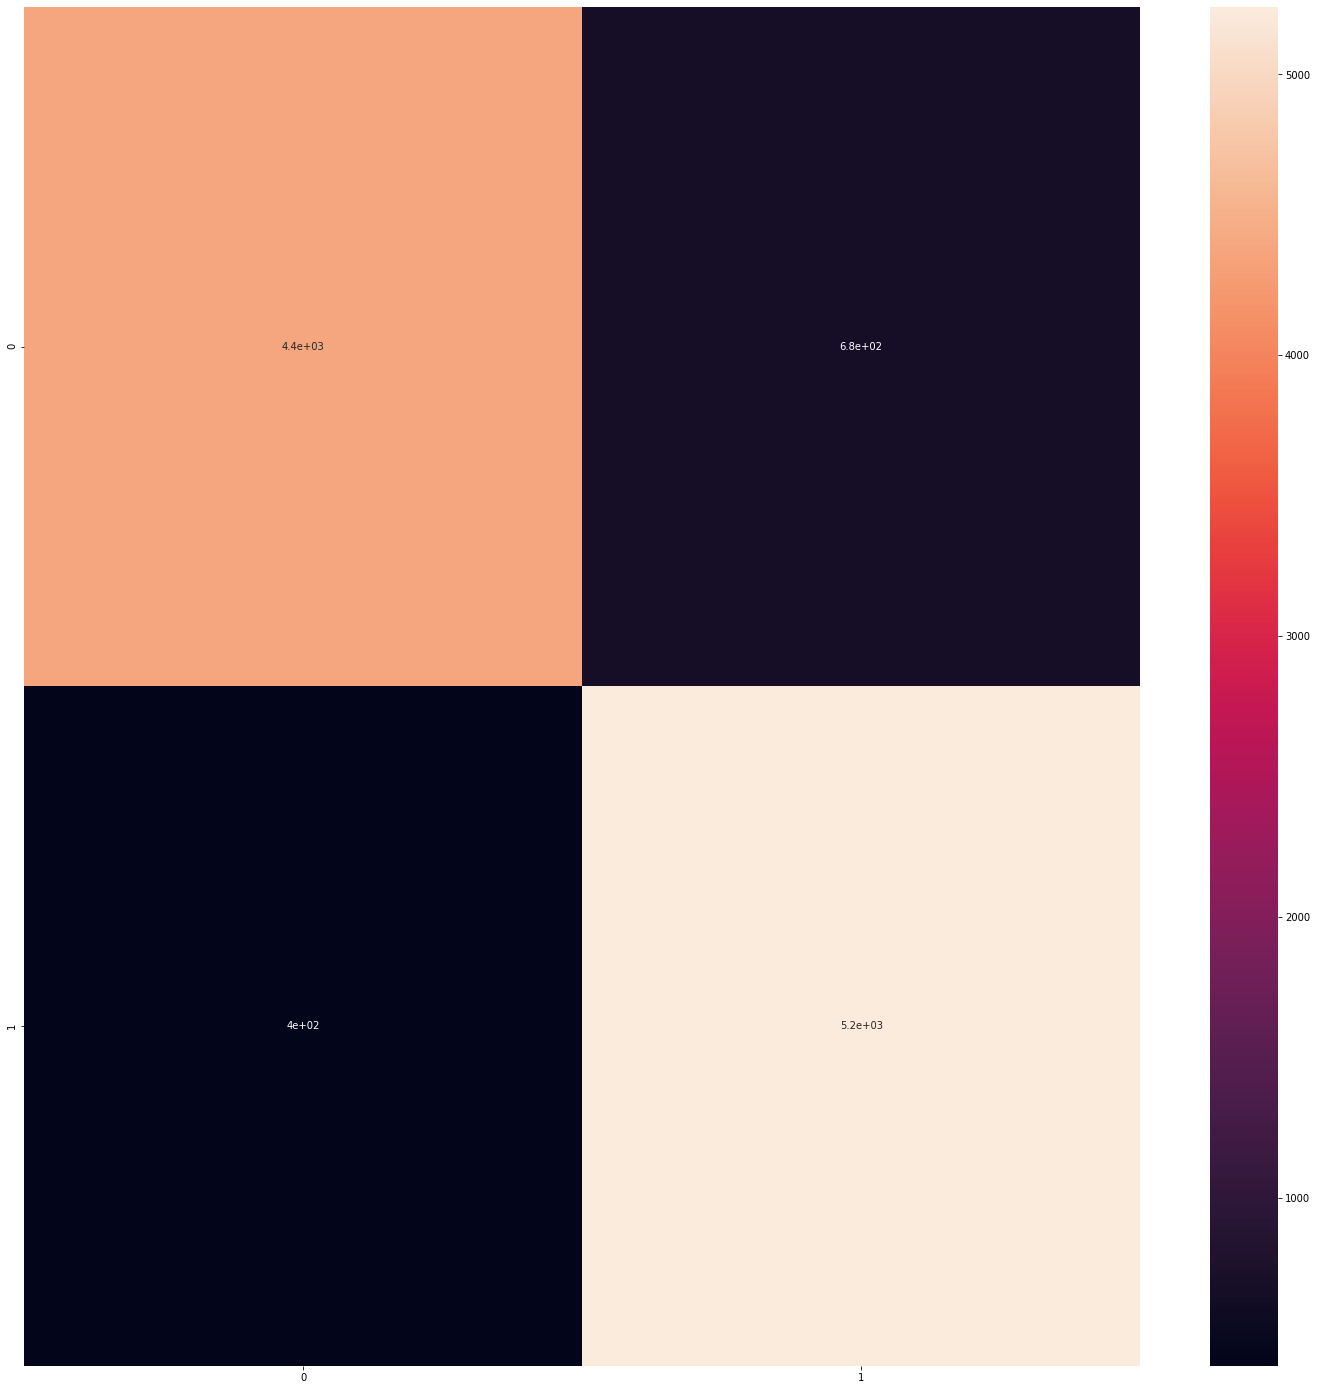

In [73]:
# NAIVE BAYES CLASSIFIER

from sklearn import naive_bayes

model = naive_bayes.MultinomialNB()
model.fit(X_train_count, y_train)

## Plot confusion matrix

pred = model.predict(X_test_count)

prediction = []
# If hte prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()

In [74]:
df_pred = pd.DataFrame(pred, columns = ['output'])

In [99]:
test = pd.concat([d.reset_index(drop=True) for d in [X_test, y_test]], axis=1)
for X,Y,Z in zip(pred, y_test, X_test):
    print("Model Score:", X, "\nactual score:", Y, "\ntext:", Z, "\n-----------------------") 

Model Score: 1 
actual score: 1 
text: watch keith olbermann flays trump helping enemies keith olbermann mince words comes donald trump avoid mincing words lights trump minions saying muslim necessary protect terrorism lawyer department justice claim court promptly smacked judge olbermann took resistance flay trump open effects racist olbermann says trump aiding enemies international organization kind congratulate trump muslim sheep clothing called islamic state isis terrorists sent bouquets issued press releases celebrating plan certainly instigate deaths american citizens night election trump alienating muslims making people america fear muslims makes muslim americans ripe radicalization pisses muslims makes ripe radicalization olbermann postulates trump wants muslim greatest possible gift isis recruitment confirmation rationalization instigating terrorist acts maybe america trump understand inevitably follow understand inevitably follow american want american president american deli

Model Score: 0 
actual score: 0 
text: italy cure coronavirus finally 
-----------------------
Model Score: 0 
actual score: 0 
text: latest california fires camel racing coronavirus tribute world photos sept 
-----------------------
Model Score: 0 
actual score: 1 
text: wannabe president barack obama meets south korean president trashing president trump indonesia president barack obama feeling nostalgic meeting south korean president moon monday minutes korea herald reported moon spoke recent meetings president trump asked obama advice improve relationship meeting came obama spoke asian leadership conference fourth congress indonesian diaspora jakarta attacked trump decision withdraw paris climate change accord paris came ambitious agreement history climate change agreement temporary absence american leadership children fighting chance obama said indonesia president said leaving office appreciated predecessor george bush silence tenure contended citizen carries duties obligations dai

text: twitter users post hilarious responses russia images putin original post post illegal russia share image putin clown https trihoop post washingtonpost april hilarious responses illegal twitter xbhslt jessica nofascistspls april like twitter scamgoggles april twitter jessica nofascistspls april like twitter zievbuddqr lisa stewart holachola april twitter syzcnkbt jessica nofascistspls april demand putin clowns went gonna capitalize meme twitter tyler function april courtesy https tjwnkzbbev twitter vgoke stranger thingamabob mikeymoosenc april 
-----------------------
Model Score: 0 
actual score: 0 
text: trump considering scott gottlieb head scott gottlieb partner world largest venture capital funds deputy commissioner food drug administration considered president elect donald trump agency according sources close transition team gottlieb venture partner enterprise associates resident fellow american enterprise institute conservative think tank based known health policy circles f

text: congress puerto rico debt restructuring authority white house congress puerto rico authority restructure debt white house said friday refusal congress island government authority deal financial challenges makes future bailout likely white house spokesman told regular news briefing 
-----------------------
Model Score: 0 
actual score: 0 
text: clinton pledge curtail fracking falls unconvinced ears hillary clinton regulate fracking existence skepticism monday failing convince industry environment groups controversial drilling practice president runner democratic party nomination debate flint michigan sunday night oppose fracking local communities polluted water companies refused disclose chemicals process time conditions think places america fracking continue place said supporters opponents fracking dismissed position campaign rhetoric collide limited powers president control activity largely regulated state level defenders fracking said president brakes drilling technique flooded

Model Score: 1 
actual score: 1 
text: carson believes poverty state mind people happy carson head department housing urban development come comments radio interview tuesday called poverty state mind live statement like coming takes meaning comes lips oversees department handles housing millions income americans statement carson interviewed conservative media personality personal friend armstrong williams carson retired neurosurgeon dealt directly poverty credits mother getting family situation stop implying people poor negative outlook life according transcript interview williams released wednesday carson away making feelings subject known think poverty large extent state mind said somebody right mindset street guarantee little right stop adding lending helping hand need improve lives right mental attitude point trying somebody wrong mindset world work right continued strong words coming charge trying roofs heads exactly living luxury income earner presented opportunities carson mothe

actual score: 0 
text: sportsmen fight trump energy plans alongside environmental left salt lake city utah republican congressman jason chaffetz utah introduced legislation month transfer million acres federally held public land state control bombarded thousands angry phone calls letters social media posts urging pressure came liberal toting conservative outdoors enthusiasts central chaffetz political base camps fear transferring federal lands state control open drilling coal mining recreation preservation hear chaffetz wrote post instagram account announcing withdrawal proud owner hunter love public lands chaffetz office respond requests comment reversal outdoor sporting groups long associated conservatism support guns rights small government collaborating environmental left fight president donald trump push open public lands energy development areas include national forests parks native american tribal territories account fifth united states recent funding data foundation center data

Model Score: 0 
actual score: 0 
text: factbox build giant wall education department president trump republican presidential candidate donald trump scored major victory series super tuesday nominating contests criticized party vague policy specifics heavy rhetoric closer look trump said trade taxes economy immigration healthcare defense nominee election policies drawn review website stump speeches debates town halls televised interviews trump complained china japan mexico vietnam india ripping devaluing currencies keeping exports sign nation trans pacific partnership trade pact renegotiate north american free trade agreement nafta mexico canada designate china currency manipulator impose countervailing duties exports wants pursue world trade organization case chinese government programs subsidize exporters trump said activist investor carl icahn charge negotiating better trade relationship china icahn said happy advise trump seek formal position trump elected trump said slap percent ta

Model Score: 1 
actual score: 0 
text: popular whatsapp advisory allegedly tatahealth homemade covid fakenews factcheck 
-----------------------
Model Score: 1 
actual score: 1 
text: watch chris cuomo shreds kellyanne conway hypocritically defending trump play scheme charitable foundation offers access public official exchange large donations called play campaign donald trump team minions kellyanne conway repeatedly accused hillary clinton clinton foundation sell access secretary state office allegations proven false matter times conservatives repeat eric donald trump caught trying sell access father eric trump foundation requiring million donations private meeting president elect exact definition play demonic rescinded offer quickly backed away scheme kellyanne conway pathetically tried defend scheme host chris cuomo took woodshed lying hypocrite think look eric wanted continue raise money charities conway remarked attempt evade cuomo question illegal scheme eric trump foundation yea

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 
actual score: 0 
text: taking sides iraqi kurdish dispute trump united states sought monday avoid openly taking sides iraqi kurdish dispute iraq capture kurdish held city kirkuk raised risk open conflict allies fight islamic state president donald trump expressed disappointment sides fighting like fact clashing taking sides trump told reporters white house years good relationship kurds know iraq place taking sides battle iraqi government forces captured major kurdish held city kirkuk monday responding kurdish referendum independence bold lightning strike transforms balance power country convoy armored vehicles iraq elite trained counter terrorism force seized kirkuk provincial government headquarters monday afternoon operation began reporter kirkuk said senator john mccain influential chairman senate armed services committee warned iraq government severe consequences misuse provided weaponry kurdish forces pentagon spokesman colonel robert manning declined speculate united states mil

text: twitter suspends chinese virologist says covid wuhan nypostより 
-----------------------
Model Score: 1 
actual score: 1 
text: baltimore police union wants independant prosecutor mosby connections freddie gray family police union came immediately mosby press conference today response assessment freddie gray case fighting claim officers wrong arrest transport gray fraternal order police lodge asking baltimore state attorney marilyn mosby appoint special prosecutor freddie gray investigation personal connection gray family attorney william billy murphy marriage city councilman officers involved tragic situation left home morning anticipation interacted home night letter states tragic situation officers involved responsible death gray ryan requests mosby appoint special independent prosecutor deep concerns conflicts presented office conducting investigation case letter states conflicts include personal professional relations gray family attorney william murphy lead prosecutor connect

actual score: 0 
text: italy renzi defends referendum italian prime minister matteo renzi tuesday defended campaign referendum constitutional reforms saying overhaul help simplify nation bureaucracy offer greater stability help europe stronger help referendum pass renzi said speaking italian interpreter white house news conference president barack obama simplify things country 
-----------------------
Model Score: 0 
actual score: 0 
text: spain police came encourage doctors work gave wanted quit 
-----------------------
Model Score: 1 
actual score: 1 
text: mike pence police illegally suppress vote tens thousands black people indiana right middle thousand scandals swirling donald trump comes running mate mike pence governor indiana pence oversaw legalized discrimination destroying state educational attempt destroy freedom press come engaged voter suppression particularly indiana black voters worse clearly fraudulent voter indiana state police raided offices indiana voter registration

actual score: 1 
text: covid wildfire wave going burn winter billhanage 
-----------------------
Model Score: 1 
actual score: 1 
text: poverty soars michigan governor wife cake february mlive posted series photos detailing snyder birthday cake aware snyder wife michigan governor rick snyder considering state declining income levels climbing poverty rates crumbling schools failing infrastructure mention flint water crisis cake grotesque display luxury opulence michigan residents fuming image credit mliveaccording mlive took hours local cake designer heather anne leavitt create cake features chanel tiffany diamond necklace nordstrom designer handbag bearing michael kors logo leavitt refused disclose cost cake saying customers include high clients december census bureau released recent year report status michigan residents data showed poverty rates increased nearly percent leadership governor rick snyder thirds michigan communities number people living federal poverty line increase snyde

Model Score: 0 
actual score: 0 
text: says constructive relationship ireland focus brexit progress london britain constructive relationship ireland focus making progress brexit negotiations prime minister theresa spokesman said friday irish election appeared likely opposition party fianna fail submitted motion confidence deputy prime minister ruling party considers breach year agreement support prime minister varadkar government feel constructive relationship ireland continue talk regularly continue focus making progress negotiation spokesman said asked political uncertainty dublin 
-----------------------
Model Score: 1 
actual score: 1 
text: massachusetts votes ignore illegals sanctuary state endangers americans massachusetts sanctuary state massachusetts supreme court ruled illegals released held federal puts americans risk tucker carlson previously interviewed state supports subverting federal listen skewed reasoning following federal ruling hailed civil liberties advocates ends 

Model Score: 0 
actual score: 0 
text: house speaker nancy pelosi wuhan china days impeachment proceedings president trump ended 
-----------------------
Model Score: 1 
actual score: 1 
text: begins obama appointed judge rules trump university records released chicago style politics buckle america barry getting warmed federal judge ordered release internal trump university documents ongoing lawsuit company including playbooks advised sales personnel market high priced courses getting rich real estate friday ruling judge gonzalo curiel cited heightened public presumptive republican presidential nominee donald trump issued response request post ruling setback trump attorneys argued documents contained trade secrets curiel order came trump railed judge boisterous diego rally handling case students alleged misled defrauded trial november trump previously questioned curiel hispanic heritage biased trump support building wall mexican border said friday curiel happens believe mexican trump c

actual score: 1 
text: cliven bundy takes charge remaining oregon militiamen says continue occupation indefinitely ammon bundy jail militants occupying malheur wildlife refuge harney county oregon cliven bundy decided matters hands letter addressed authorities responsible arrests militants death cliven bundy says folks occupying refuge fight death letter read notice people harney county people citizens united states notice retain possession harney county resource center harney county resource center militants given refuge place original letter posted bundy ranch facebook page cdata cdata cdata function getelementbyid return createelement connect facebook en_us xfbml version parentnode insertbefore document script facebook jssdk notice harney sheriff share share share posted bundy ranch monday february stunt shows bundy idiot requested occupation arrests death lavoy finicum bundy said media interview saying cliven bundy taking control things retain lost months gonna ammon message messag

Model Score: 0 
actual score: 0 
text: clinton loses sanders coal state west virginia york democratic presidential candidate bernie sanders defeated hillary clinton tuesday west virginia primary winning voters deeply skeptical economy signaling difficulty clinton industrial states general election loss slows clinton march nomination heavily favored democratic candidate election november match donald trump clinton need working class voters rust belt includes states ohio pennsylvania trump contests west virginia nebraska handily tuesday presumptive republican nominee meet party leaders congress thursday including house representatives speaker paul ryan ryan said week ready endorse trump trump said sunday decide wanted ryan preside party july convention trump said interview tuesday night like ryan chair convention planned good wants good party york billionaire said trump zeroed clinton protracted battle sanders year senator vermont taunted clinton recent days saying close deal beating san

actual score: 1 
text: anti government terrorists forgot snacks want send mail thursday blaine cooper anti government terrorists participating armed takeover bird sanctuary oregon snacks social media according terrorist group known llqueda armed militants decided seize year wildlife refuge symbol wrong america able public lands turn freeloading cattle loose feed american taxpayers ride ancient archaeological sites according ammon bundy malheur national wildlife refuge established came market stupidity right wing extremism timeless case needed proof dumbest armed takeover bird sanctuary anti government terrorists told america plan stay holed inside visitor building malheur national wildlife refuge long takes years asking people send snacks secretive press conference held second llqueda armed occupation federal wildlife refuge bundy told press plan plan going months accomplish kind idiotic plan involves living visitor building wildlife sanctuary months years necessary include packing sna

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model Score: 0 
actual score: 0 
text: mainstream republicans fret trump cruz strengthen presidential race north charleston weeks contest presidential race republicans business leaders fear party hijacked likes donald trump cruz little comfort latest debate candidates billionaire developer political experience senator texas reputation clashing colleagues stood center stage thursday night dominated proceedings mainstream hopefuls florida governor bush jersey governor chris christie ohio governor john kasich senator marco rubio florida left nipping heels squabbling characteristic bravado trump dubbed winner friday speaking people living history farms iowa called debate interesting said pundits night treating nicely trump told msnbc overnight polls showed winning debate saying cruz strident inappropriate comments know nice trump said msnbc morning program think hurt night trump cruz opinion polls locked tight struggle iowa caucuses clashed points befitting leading status left little room 

actual score: 0 
text: turkey warns jerusalem embassy grave mistake brussels turkish foreign minister mevlut cavusoglu said wednesday grave mistake united states embassy israel jerusalem warned secretary state tillerson bilateral meeting tillerson nato headquarters cavusoglu said grave mistake embassy bring stability chaos instability world said adding told tillerson felt reiterate meeting nato alliance foreign ministers meeting 
-----------------------
Model Score: 1 
actual score: 1 
text: millionaire sean hannity tried fake middle class gets destroyed twitter news host donald trump cheerleader sean hannity busted trying pretend process defending trump time disastrous debate appearance monday night hannity lashed press overpaid friends media chauffeured limousines like fine steakhouses expensive wine lifestyles based statement think hannity regular sixpack toiling away middle class income best trying ends meet paying mortgage electric keeping family course host highly rated cable new

Model Score: 0 
actual score: 0 
text: obama administration expects close guantanamo prison white house president barack obama committed closing prison terrorism suspects guantanamo cuba administration expects complete task white house said thursday going best closed expectation white house spokesman josh earnest said news briefing 
-----------------------
Model Score: 0 
actual score: 0 
text: transcanada final decision keystone december transcanada corp canada pipeline operator final investment decision keystone project december company said friday reported better expected profit december timeline time company publicly deadline making investment decision project president donald trump approved keystone march reversing decision barack obama investment decision based shipper demand regulatory outcome state nebraska project passes paul miller executive vice president president liquid pipeline transcanada said conference release quarterly results assessment factors drive investment decis

Model Score: 0 
actual score: 0 
text: tells britain protect data delete brexit brussels european union wants britain protect data storage continental europeans brexit maintain bans cheap imitations locally branded produce like cognac parma proposals position papers published european commission brexit negotiators thursday consultation member states offered glimpse thinking brussels future trade ties britain despite refusal start talks british government voiced frustration refusal negotiators open discussions future free trade pact london makes concessions elements settled avoid legal chaos britain leaves march spelling wants happen issues brexit union wants point example protection personal data gathered english channel trademarks intellectual property paper data protection says britain continue data gathered exit left long continues applying level protection destroy data britain lose access networks information systems databases leaves paper says include example information underpinn

Model Score: 0 
actual score: 0 
text: congress votes apply magnitsky human rights globally legislation expanding magnitsky human rights russian citizens cover abusers country passed senate thursday annual defense policy leaving landmark measure verge legislation included pass national defense authorization ndaa setting policy department defense despite recent election republican donald trump president trump signaled softer line russia vehemently opposes original sergei magnitsky rule accountability expansion magnitsky imposed visa bans asset freezes russian officials linked death prison sergei magnitsky year russian whistleblower backers pushed years expand impact country significant acts corruption sanctionable offenses visiting united states financial institutions privileges extended worst actors international senator cardin democrat senate foreign relations committee said statement cardin pushed measure republican senator john mccain chairman senate armed services committee house r

-----------------------
Model Score: 1 
actual score: 1 
text: cdcemergency takeaction slow spread covid wearing cloth face covering public spaces keeping feet 
-----------------------
Model Score: 1 
actual score: 1 
text: cover real news heated debate obsession trump alisyn camerota sparred scott taylor president donald trump weekend beats vince mcmahon graphic superimposed commissioner face notice camerota keeps going taylor shuts truth awesome camerota political hack agenda wants president trump look interview interview blatantly attacks trump administration knows trump supporters attempt interview camerota previous report camerota trump press secretary calls camerota unbelievable questions know frustrating logical interview hysterical sean spicer runs circles political hack camerota gets good mark know frustrating logical sean spicer allison camerota https youtube watch scamerota break spicer good debate 
-----------------------
Model Score: 0 
actual score: 1 
text: defense secre

actual score: 0 
text: stricter missouri abortion rules effect legal fight abortion regulations took effect tuesday missouri critics argue difficult women access procedure judge monday declined block requirement physicians performing abortions inform patients abortion risks hours procedure previously different provider mandated information means repeat doctor visits women seeking abortions travel hundreds miles reach missouri clinics said bonyen gilmore spokeswoman planned parenthood great plains shortage abortion doctors said organization sued stop regulations provider requirement making difficult possible obtain abortion gilmore said phone interview tuesday abortion access chipped away seemingly moderate restriction time missouri attorney general josh hawley praised statement issued late monday saying enacts sensible regulations protect health women missouri continue vigorously defend provider restriction broader abortion regulations went effect monday passed missouri lawmakers july 

text: mexico military helicopter crashes northern state seven presumed dead mexico city mexican military helicopter crashed friday northern state durango seriously injuring military member aboard likely killing seven defense ministry said statement helicopter bell model crashed kilometers miles northeast town salto mountainous state durango training flight survivor grave condition hospital authorities searching bodies seven military members presumed remains aircraft northern state durango borders sinaloa state home sinaloa drug cartel military authorities investigating happened helicopter ministry said 
-----------------------
Model Score: 1 
actual score: 1 
text: picture proves michael moore wrong socialism capitalism michael moore think socialism better capitalism tweeted night socialism fairness 
-----------------------
Model Score: 1 
actual score: 1 
text: trump seething congressman obliterates nasty woman debate insult notable moments night presidential debate thanks republican 

Model Score: 1 
actual score: 1 
text: tampon women suing state unfair calling tampons luxury item proof government calling tampons luxury item ridiculous thing heard condoms taxed time month time york state imposing sales tampons according group women pissed women filed class action lawsuit calling empire state giving tampons preferential treatment male medical products instance rogaine condoms foot powder exempt standard sales state dept taxation finance says tampons control normal bodily function maintain personal cleanliness plaintiffs tampons luxury items medical necessities avoid infection nasty circumstances want lifted immediately read 
-----------------------
Model Score: 0 
actual score: 0 
text: appeals court delays release bridgegate conspirators list york appeals court tuesday postponed deadline prosecutors jersey reveal list unindicted conspirators called bridgegate criminal case involving allies governor chris christie circuit court appeals granted minute emergency reque

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

